In [69]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet
from perceptualtests.color_matrices import *
from perceptualtests.colored_squares import create_colored_square

In [2]:
path_cmf = '/media/disk/vista/Papers/A_Vision_Talks/psycho_paper/vision_py/cmf_ciexyz.mat'

# Load the CMF data

In [3]:
T_lambda = sio.loadmat(path_cmf)['T_lambda'].astype(np.float32)
T_lambda

array([[3.8000000e+02, 2.6899001e-03, 1.9999999e-04, 1.2260000e-02],
       [3.8100000e+02, 3.2147770e-03, 2.3911201e-04, 1.4654440e-02],
       [3.8200000e+02, 3.7392753e-03, 2.7822400e-04, 1.7047860e-02],
       ...,
       [8.2300000e+02, 1.9235094e-06, 7.4575200e-07, 1.8017809e-10],
       [8.2400000e+02, 1.7805264e-06, 6.9069603e-07, 1.6752065e-10],
       [8.2500000e+02, 1.6377001e-06, 6.3563999e-07, 1.5476000e-10]],
      dtype=float32)

# Functions

In [4]:
def background_stimulus_tf(lambdas, background):
    """
    Generates a quasi-monochromatic spectrum. Gaussian centered in central lambda with desired width and peak on max_radiance over a background.
    """
    spectrum = tf.cast(tf.ones_like(lambdas, dtype=tf.float32)*background, tf.float32)
    return spectrum

def monochomatic_stimulus_2_tf(central_lambda, lambdas, width, max_radiance, background):
    """
    Generates a quasi-monochromatic spectrum. Gaussian centered in central lambda with desired width and peak on max_radiance over a background.
    """
    spectrum = max_radiance*tf.cast(tf.exp(-(lambdas-central_lambda)**2/width**2), tf.float32) + background_stimulus_tf(lambdas, background)
    return spectrum

def atd2nrgb_tf(atd, gamma):
    """
    Changes from atd to nrgb values (ready to be displayed in the screen). 
    Expects and atd color column vector or images.

    Parameters
    ----------
    gamma: 
        Expects only the number, i.e. 2.2
    """
    rgb = Mxyz2ng @ Matd2xyz @ atd

    if tf.reduce_min(rgb) < 0 or tf.reduce_max(rgb) > 1:
        sat = 1
        rgb = tf.clip_by_value(rgb, 0, 1)
    else:
        sat = 0

    if type(gamma) == list:
        rgb = tf.pow(rgb, 1/gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**(1/gamma)
    else:
        print('Error')
    return rgb

def xyz2nrgb_tf(xyz, gamma):
    """
    Changes from xyz to nrgb values (ready to be displayed in the screen). Expects and xyz color column vector or images.
    """
    rgb = Mxyz2ng @ xyz
    rgb_2 = rgb

    if tf.reduce_min(rgb) < 0 or tf.reduce_max(rgb) > 1:
        sat = 1
        rgb = tf.clip_by_value(rgb, 0, 1)
    else:
        sat = 0

    if type(gamma) == list:
        rgb = tf.pow(rgb, 1/gamma[:,None])
    elif type(gamma) == float:
        rgb = rgb**(1/gamma)
    else:
        print('Error')
    return sat, rgb, rgb_2


def norm_spectrum_luminance_tf(lambdas, spectrum, luminance):
    """
    Normalize a spectrum with a desired luminance. Returns the original luminance and the new lambdas and normalized spectrum after the interpolation.
    """
    V_l = T_lambda[:,2]
    lambdas_Y = T_lambda[:,0]

    min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas])), np.max(np.concatenate([lambdas_Y, lambdas]))
    new_lambda = np.arange(min_abs, max_abs, 1, dtype=np.float32)

    interpol_spectrum = tfp.math.interp_regular_1d_grid(new_lambda, lambdas[0], lambdas[-1], 
                                                        spectrum, fill_value='extrapolate')
                                                        # fill_value_below=spectrum[0], fill_value_above=spectrum[-1])
    interpol_V_l = tfp.math.interp_regular_1d_grid(new_lambda, lambdas_Y[0], lambdas_Y[-1], 
                                                            V_l, fill_value='extrapolate')
                                                            # fill_value_below=V_l[0], fill_value_above=V_l[-1])
    Y = km*tfp.math.trapz(y=interpol_spectrum*interpol_V_l, x=new_lambda)
    interpol_spectrum = luminance * interpol_spectrum/Y
    return Y, new_lambda, interpol_spectrum


def spect2tri_xyz_tf(lambdas, spectrum, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None):
    """
    Calculates the tristimulus values of a spectrum. It needs the wavelengths and the spectrum. Reflectance with its wavelenghts are optional.
    Spectrum_luminance is optional and it normalizes the spectrum with the desired luminance.
    """
    lambdas_Y = T_lambda[:,0]

    if spectrum_luminance is not None:
        Y, lambdas, spectrum = norm_spectrum_luminance_tf(lambdas, spectrum, spectrum_luminance)

    if (reflectance is not None) and (lambdas_reflectance is not None):
        min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas, lambdas_reflectance])), np.max(np.concatenate([lambdas_Y, lambdas, lambdas_reflectance]))
        new_lambda = np.arange(min_abs, max_abs, 1, dtype=np.float32)

        interpol_reflectance = tfp.math.interp_regular_1d_grid(new_lambda, lambdas_reflectance[0], lambdas_reflectance[-1], 
                                                               reflectance, fill_value='extrapolate')
                                                            #    fill_value_below=reflectance[0], fill_value_above=reflectance[-1])
        interpol_spectrum = tfp.math.interp_regular_1d_grid(new_lambda, lambdas[0], lambdas[-1], 
                                                            spectrum, fill_value='extrapolate')
                                                            # fill_value_below=spectrum[0], fill_value_above=spectrum[-1])

        interpol_spectrum = interpol_spectrum*interpol_reflectance

    else:
        min_abs, max_abs = np.min(np.concatenate([lambdas_Y, lambdas])), np.max(np.concatenate([lambdas_Y, lambdas]))
        new_lambda = np.arange(min_abs, max_abs, 1, dtype=np.float32)

        interpol_spectrum = tfp.math.interp_regular_1d_grid(new_lambda, lambdas[0], lambdas[-1], 
                                                            spectrum, fill_value='extrapolate')
                                                            # fill_value_below=spectrum[0], fill_value_above=spectrum[-1])

    tristimulus_values = np.zeros((3,1))
    for i in range(3):
        T_i = T_lambda[:,i+1]
        T_i = tfp.math.interp_regular_1d_grid(new_lambda, lambdas_Y[0], lambdas_Y[-1], 
                                              T_i, fill_value='extrapolate')
                                            #   fill_value_below=T_i[0], fill_value_above=T_i[-1])

        tristimulus_values[i,0] = km*tfp.math.trapz(y=interpol_spectrum*T_i, x=new_lambda)

    return tristimulus_values


def generate_images_rgb_tf(weights, central_lambdas, spectrum_lambda, spectrum_white, shape=(1,384,512,3)):
    # spectrums = np.array([monochomatic_stimulus_2(central_lambdas[i], lambdas, width=5, max_radiance=max_radiance*tf.abs(weights[i]), background=background) for i in range(len(central_lambdas))])

    for i in range(len(central_lambdas)):
        spectrum = monochomatic_stimulus_2_tf(central_lambdas[i], lambdas, width=5, max_radiance=max_radiance*tf.abs(weights[i]), background=background)
        if weights[i] >= 0:
            spectrum_lambda = spectrum_lambda + spectrum
        else:
            spectrum_white = spectrum_white + spectrum

    tristimulus_xyz_lambda = spect2tri_xyz_tf(tf.cast(lambdas, tf.float32), tf.cast(spectrum_lambda, tf.float32),
                                            lambdas_reflectance=None, reflectance=None, spectrum_luminance=None)
    tristimulus_xyz_white = spect2tri_xyz_tf(tf.cast(lambdas, tf.float32), tf.cast(spectrum_white, tf.float32),
                                            lambdas_reflectance=None, reflectance=None, 
                                            spectrum_luminance=tristimulus_xyz_lambda[1,0].item())

    sat, rgb_lambda = xyz2nrgb_tf(tristimulus_xyz_lambda, gamma)
    sat, rgb_white = xyz2nrgb_tf(tristimulus_xyz_white, gamma)

    img_lambda = tf.ones(shape, dtype=tf.float32)*tf.cast(tf.transpose(rgb_lambda, perm=[1,0]), tf.float32)
    img_white = tf.ones(shape, dtype=tf.float32)*tf.cast(tf.transpose(rgb_white, perm=[1,0]), tf.float32)

    return img_lambda, img_white

# Generate the spectrum

In [13]:
central_lambdas = tf.constant([475., 500., 580., 700.], dtype=tf.float32)
norm_grads = False
learning_rate = 3e-4
losses = []
gradients = []
lambdas = tf.convert_to_tensor(np.linspace(380,770,300), dtype=tf.float32)
central_lambda=tf.constant(550, dtype=tf.float32)
km = 683
width = tf.constant(np.inf, dtype=tf.float32)
max_radiance=tf.constant(1.5e-3, dtype=tf.float32)
background=tf.constant(0.5e-4, dtype=tf.float32)

In [6]:
spectrum_lambda = monochomatic_stimulus_2_tf(central_lambda=central_lambda, 
                                             lambdas=lambdas, 
                                             width=5, 
                                             max_radiance=max_radiance, 
                                             background=background)

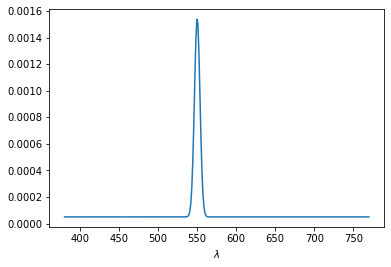

In [9]:
plt.plot(lambdas, spectrum_lambda)
plt.xlabel(r'$\lambda$')
plt.show()

In [14]:
xyz = spect2tri_xyz_tf(lambdas, spectrum_lambda, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)
xyz.shape

(3, 1)

In [30]:
def xyz2nrgb(xyz):
    """
    xyz is expected to be a column vector.
    """
    return (Mxyz2ng @ xyz)**(1/2)

In [31]:
rgb = xyz2nrgb(xyz)
rgb.shape, rgb

((3, 1),
 array([[0.16153093],
        [0.31413593],
        [0.11695624]]))

In [53]:
img_size = (384,512)
square_size = (96,128)

In [33]:
def image_from_column(column_vector, img_size):
    return np.ones(shape=(*img_size, 3)) * column_vector[None,None,:,0]

In [34]:
img = image_from_column(rgb, img_size)
img.shape

(384, 512, 3)

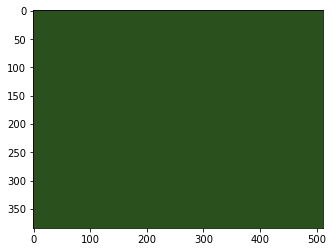

In [35]:
plt.imshow(img)
plt.show()

## Generate the background

In [48]:
spectrum_white = monochomatic_stimulus_2_tf(central_lambda=central_lambda, 
                                            lambdas=lambdas, 
                                            width=np.inf, 
                                            max_radiance=0, 
                                            background=background)
xyz_bg = spect2tri_xyz_tf(lambdas, spectrum_white, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)
rgb_bg = xyz2nrgb(xyz_bg)
img_bg = image_from_column(rgb_bg, img_size) 

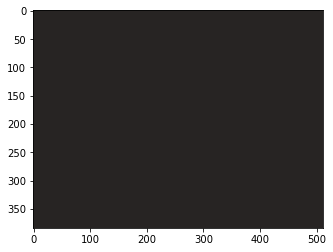

In [51]:
plt.imshow(img_bg)
plt.show()

# Cycling through all the lambdas

In [ ]:
central_lambdas = tf.constant([475., 500., 580., 700.], dtype=tf.float32)
norm_grads = False
learning_rate = 3e-4
losses = []
gradients = []
lambdas = tf.convert_to_tensor(np.linspace(380,770,300), dtype=tf.float32)
central_lambda=tf.constant(550, dtype=tf.float32)
km = 683
width = tf.constant(np.inf, dtype=tf.float32)
max_radiance=tf.constant(1.5e-3, dtype=tf.float32)
background=tf.constant(0.5e-4, dtype=tf.float32)

In [58]:
colored_square = create_colored_square(img_size=img_size,
                                       square_size=square_size,
                                       square_color=rgb.ravel(),
                                       bg_color=rgb_bg.ravel())

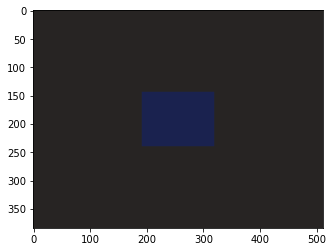

In [59]:
plt.imshow(colored_square)
plt.show()

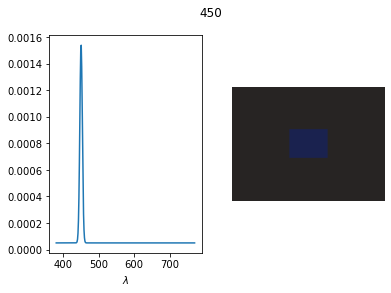

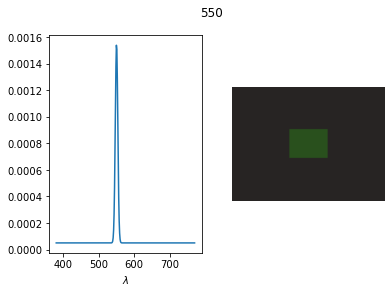

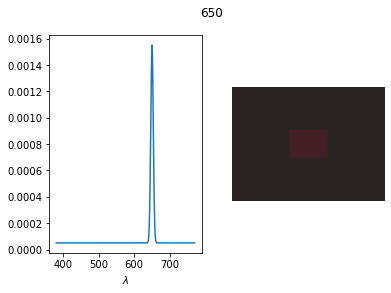

In [61]:
for central_lambda in [450, 550, 650]:
    
    spectrum_lambda = monochomatic_stimulus_2_tf(central_lambda=central_lambda, 
                                                lambdas=lambdas, 
                                                width=5, 
                                                max_radiance=max_radiance, 
                                                background=background)
    xyz = spect2tri_xyz_tf(lambdas, spectrum_lambda, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)
    rgb = xyz2nrgb(xyz)
    img = create_colored_square(img_size=img_size,
                                square_size=square_size,
                                square_color=rgb.ravel(),
                                bg_color=rgb_bg.ravel())                                     
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(lambdas, spectrum_lambda)
    axes[0].set_xlabel(r'$\lambda$')
    axes[1].imshow(img)
    axes[1].axis('off')
    plt.suptitle(central_lambda)
    plt.show()

# Load the model

In [75]:
class FakeNetwork():
    def __call__(self, X):
        return X
    def predict(self, X):
        return self(X)

In [76]:
model = FakeNetwork()

## Get the response to the background

In [77]:
response_bg = model.predict(img_bg[None,:,:,:])
response_bg.shape

(1, 384, 512, 3)

## Create and pass the stimuli

In [78]:
visses = []
for central_lambda in tqdm(lambdas):
    ## Obtain the spectrum
    spectrum_lambda = monochomatic_stimulus_2_tf(central_lambda=central_lambda, 
                                                lambdas=lambdas, 
                                                width=5, 
                                                max_radiance=max_radiance, 
                                                background=background)
    ## Get its corresponding tristimulus values
    xyz = spect2tri_xyz_tf(lambdas, spectrum_lambda, lambdas_reflectance = None, reflectance = None, spectrum_luminance = None)
    rgb = xyz2nrgb(xyz)
    ## Build an image to pass through PerceptNet
    img = create_colored_square(img_size=img_size,
                                square_size=square_size,
                                square_color=rgb.ravel(),
                                bg_color=rgb_bg.ravel())                                      
    ## Get the response
    response = model.predict(img[None,:,:,:])
    ## Difference respect to the background
    vis = np.sqrt(np.sum((response_bg - response)**2))
    visses.append(vis)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_16614/1043697726.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (Mxyz2ng @ xyz)**(1/2)


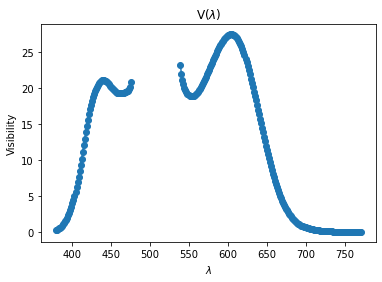

In [79]:
plt.plot(lambdas, visses, '-o')
plt.xlabel(r'$\lambda$')
plt.ylabel('Visibility')
plt.title(r'V($\lambda$)')
plt.show()